In [9]:
import ase
import ase.data
from ase.visualize import view

import numpy as np
import matplotlib.pyplot as plt

from skimage.morphology import local_maxima
from skimage.feature import peak_local_max

from molnet.data.utils import get_image_and_atom_map_np

In [10]:
def generator():
    for i in range(1000):
        x, y, xyz = get_image_and_atom_map_np(
            '/l/data/small_fragments/afm.h5',
            np.array([1, 6, 7, 8, 9]),
            i,
            "train",
            2.0,
            0.125,
            0.3
        )
        if x is None:
            continue

        yield x, y, xyz

gen = generator()

(128, 128, 10) (5, 128, 128, 21) (20, 5)


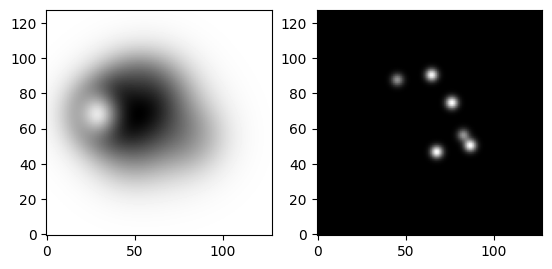

In [5]:
x, y, xyz = next(gen)
print(x.shape, y.shape, xyz.shape)

ax = plt.subplot(1, 2, 1)
ax.imshow(x[:, :, 0], cmap='gray', origin='lower')
ax = plt.subplot(1, 2, 2)
ax.imshow(y[0].sum(axis=(-1)), cmap='gray', origin='lower')

In [6]:
peaks = peak_local_max(y, min_distance=1, threshold_rel=0.1, exclude_border=0)
print(peaks.shape)

(14, 4)


In [7]:
scan_window = np.array(
    [
        [2.0, 2.0, 0.0],
        [18.0, 18.0, 2.0]
    ]
)

In [8]:
# convert peaks into xyz coordinates using the scan window
index_to_species = {0: 'H', 1: 'C', 2: 'N', 3: 'O', 4: 'F'}
peaks_xyz = peaks[:, [2, 1, 3]] * scan_window[1] / y.shape[1:]
peaks_z = peaks[:, 0]
mol = ase.Atoms(
    positions=peaks_xyz,
    symbols=[index_to_species[i] for i in peaks_z],
)

view(mol)

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/molnet/bin/python...>

In [13]:
cov = ase.data.covalent_radii

(119,)
